## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
df_full_train = df_full_train.reset_index(drop=True)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train['default'].values
y_val = df_val['default'].values
y_test = df_test['default'].values

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [12]:
auc_scores = {}
for col in numerical:
    if col != 'default':
        auc = roc_auc_score(df_train['default'], df_train[col])
        if auc < 0.5:
            auc = roc_auc_score(df_train['default'], -df_train[col])
        auc_scores[col] = auc
sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

[('seniority', 0.7093778624491943),
 ('income', 0.682006666132633),
 ('assets', 0.6486042567122802),
 ('amount', 0.5910773431595518),
 ('age', 0.5732933272499939),
 ('time', 0.5608662489595051),
 ('debt', 0.5047829675783548),
 ('price', 0.5043329862114843),
 ('expenses', 0.5009184217217011)]

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [13]:
print("Answer Question 1:", 'seniority')

Answer Question 1: seniority


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [14]:
small_subset = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [15]:
df_full_train_small = df_full_train[small_subset]

df_train_small = df_train[small_subset]
df_val_small = df_val[small_subset]
df_test_small = df_test[small_subset]

In [16]:
dv_small = DictVectorizer(sparse=False)

train_dict_small = df_train_small.to_dict(orient='records')
X_train_small = dv_small.fit_transform(train_dict_small)

val_dict_small = df_val_small.to_dict(orient='records')
X_val_small = dv_small.transform(val_dict_small)

model_small = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model_small.fit(X_train_small, y_train)
y_pred = model_small.predict_proba(X_val_small)[:,1]

round(roc_auc_score(y_val, y_pred), 3)

0.811

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [17]:
print("Answer Question 2:", 0.812)

Answer Question 2: 0.812


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [18]:
scores = []

thresholds = np.linspace(0.0, 0.93, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, precision, recall))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']

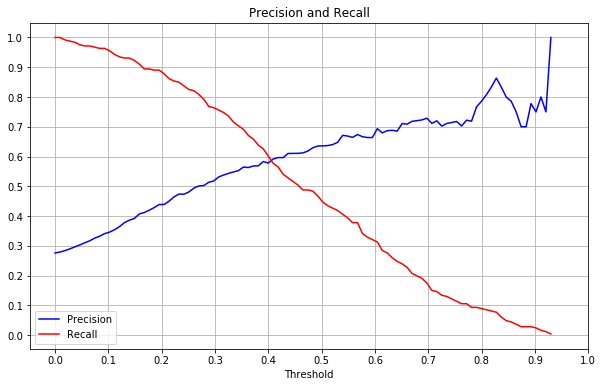

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df_scores.threshold, df_scores.precision, color='blue', linestyle='solid', label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, color='red', linestyle='solid', label='Recall')
plt.legend()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('Threshold')
plt.title('Precision and Recall')
plt.grid()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [20]:
print("Answer Question 3:", 0.4)

Answer Question 3: 0.4


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [21]:
scores = []

thresholds = np.linspace(0.0, 0.93, 101)

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    scores.append((t, tp, fp, fn, tn, precision, recall, f1))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1']

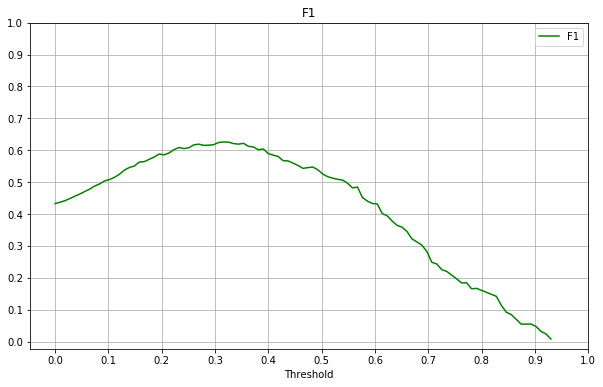

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_scores.threshold, df_scores.f1, color='green', linestyle='solid', label='F1')
plt.legend()
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('Threshold')
plt.title('F1')
plt.grid()
plt.show()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [23]:
print("Answer Question 4:", 0.3)

Answer Question 4: 0.3


## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [24]:
small_subset = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [25]:
def train(df, y, C=1.0):
    
    cat = df[small_subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)    
    # X = dv.fit_transform(cat)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    
    cat = df[small_subset].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [27]:
aucs = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train.default.values

    df_val = df_full_train.iloc[val_idx]
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [28]:
np.array(aucs).round(3)

array([0.826, 0.825, 0.788, 0.825, 0.805])

In [29]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.814 ± 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [30]:
print("Answer Question 5:", 0.014)

Answer Question 5: 0.014


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [31]:
small_subset = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [32]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.809 ± 0.013
C=0.1, auc = 0.812 ± 0.013
C=1, auc = 0.814 ± 0.015
C=10, auc = 0.813 ± 0.014


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [33]:
print("Answer Question 6:", 'C=1')

Answer Question 6: C=1


## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.